# Deep Learning Assignment - 02 , Set - 5 

## Problem - 01, Group - 029

## Image Captionining

## Library Imports

In [66]:
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from datetime import datetime

import warnings
import os
warnings.simplefilter("ignore")

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

## Valudate GPU Availability

In [67]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


## Data Visualization and Augmentation

In [68]:
# Read the pickle file

import pickle
with open('../../../LargeDatasets/CNNDatasets/ImageCaptioning/set_0.pkl', 'rb') as f:
    imagelist = pickle.load(f)

In [69]:
# From the pickle list loaded, we will populate a dataframe

imageframe = pd.DataFrame(columns=["CaptionID", "ImageName", "Caption"])

for index in range(len(imagelist)):
    string = imagelist[index]
    splitparts = string.split("\t")
    subparts = splitparts[0].split("#")
    rowDict = {'CaptionID': subparts[1], 'ImageName': subparts[0], 'Caption': splitparts[1]}
    imageframe = imageframe.append(rowDict, ignore_index=True)

# Check the initial rows after dataframe populate
imageframe.head()


,CaptionID,ImageName,Caption
0,4,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .
1,4,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...
2,4,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .
3,0,95734038_2ab5783da7.jpg,A man on a bike nest to a river .
4,1,241346146_f27759296d.jpg,A football player try tackle another player wh...


In [70]:
# Check few unique information from the dataframe

print(f"Number of Unique captionID - {imageframe['CaptionID'].nunique()}")
print(f"Number of Unique Images - {imageframe['ImageName'].nunique()}")

Number of Unique captionID - 5
Number of Unique Images - 8037


In [71]:
# Read the actual images directory

dir_images = '../../../LargeDatasets/CNNDatasets/ImageCaptioning/Flicker8k_Dataset'

images = os.listdir(dir_images)
print(f"Number of images in the directory - {len(images)}")

Number of images in the directory - 8091


### Plotting few images with captions

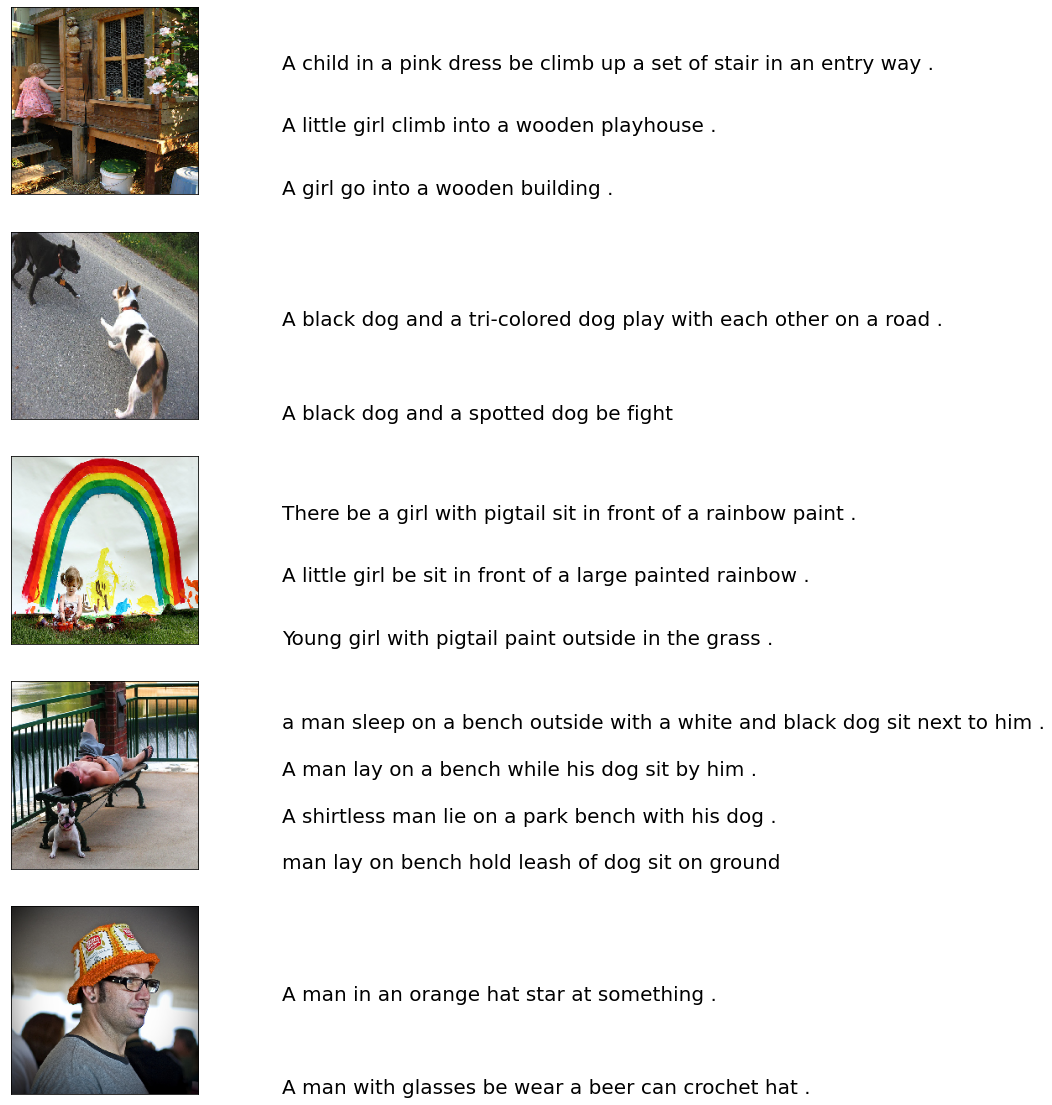

In [72]:
target_size = (224,224,3)

count = 1
fig = plt.figure(figsize=(10,20))

filenames = np.unique(imageframe.ImageName.values)

for item in np.unique(imageframe.ImageName.values)[:5]:
    filename = dir_images + '/' + item
    captions = list(imageframe["Caption"].loc[imageframe["ImageName"] == item].values)
    image_load = tf.keras.preprocessing.image.load_img(filename, target_size=target_size)
        
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Data Preparation for Model Building

### We will build a key value pair dictionary for captions with Key-Image Name and Value is the captions

In [73]:
# load the caption file & read it
def load_caption_file():
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in imagelist:
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

In [74]:
# create the dictionary
captions_dict = load_caption_file()

### Use the captions dictionary to run text processing on captions

- lowercase conversion
- removal of punctuations
- tokenization
- Add a start and end token to identify the actual length of the caption

In [75]:
import string

# dictionary to store the cleaned captions
clean_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    clean_captions_dict[caption_id] = 'startcap ' + ' '.join(caption_text) + ' endcap'


# print the first item from the clean captions
print('"' + list(clean_captions_dict.keys())[0] + '"' + ' : ' + clean_captions_dict[list(clean_captions_dict.keys())[0]])
print(f"length of the cleaned dictionary - {len(clean_captions_dict)}")

"318667317_108c402140" : startcap man in black hoodie be hold paper sign endcap
length of the cleaned dictionary - 8037


In [76]:
# Check for only those images which has caption

image_with_caption = {}
image_index = list(clean_captions_dict.keys())

image_with_caption = [ image.split('.')[0] for image in os.listdir(dir_images) if image.split('.')[0] in image_index ]

print(f"Check the first image name with caption - {image_with_caption[0]}")
print(f"Length of the image with caption list - {len(image_with_caption)}")

Check the first image name with caption - 3574627719_790325430e
Length of the image with caption list - 8036


### Train, Test and Validation Split

#### We will just keep 10 images for testing, rest all will be used for training and validation

In [77]:
train_validation_image_set = image_with_caption[0:8026]
test_image_set = image_with_caption[8026:8036]

# Check the test_image_set
test_image_set

['3145967309_b33abe4d84',
 '3590647207_2d4ec3f52c',
 '2045562030_654ddea5e5',
 '2107838729_a527e434bd',
 '125319704_49ead3463c',
 '3571039224_b34fa2f94c',
 '2963672852_c28043bb2c',
 '3162289423_4ca8915d0c',
 '2746910139_77ba5be2c5',
 '3558370311_5734a15890']

## Model Building

### We would need to extract the features - Using pretrained VGG16

In [78]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = tf.keras.applications.vgg16.VGG16()
    
    # re-structure the model
    model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = tf.keras.applications.vgg16.preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=1)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature 
    
    return features

In [79]:
# We will beging feature extraction

start = datetime.now()
train_validate_features = extract_features(dir_images, train_validation_image_set)
end = datetime.now()
print(f"The feature extraction completed in time - {end - start}")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   